# Preprocessing

In [1]:

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"

!cp "$root_path/modules/lib.py" .
!cp "$root_path/modules/plots.py" .
!cp "$root_path/modules/metrics.py" .




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import importlib
from datetime import datetime

from keras.initializers import glorot_uniform

import lib
import plots
import metrics

tf.keras.backend.clear_session()

## Parameters

In [3]:
# Deafault Res: 606x468 (ar 101 : 78)

# Tested Res's:
# 224x160 (ar 7 : 5)
# 384x288
# 576x432
# 512x384
input_res = (384, 288)

seed = 42

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 1e-3,                      
          'momentum': 0.98,                        
          'nEpoches': 100,                        
          }

ratio_test = 0.85
ratio_val  = 0.8

lib.create_dump([params, seed], dumps_path + "params_du")

type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

## Data loading 

In [4]:
# LOAD & SPLIT DATA ============================================================
'''
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")

'''

'\nmode = 1  #\xa0mode = 0: Random Split\n          #\xa0mode = 1: Split for Patients\n          \ndataset_list = lib.get_dataset_list(\n                                mode, \n                                path_, \n                                imgs_list_path, \n                                params, \n                                ratio_test, \n                                ratio_val, \n                                seed, \n                                modality)\n\n# Dumping splitted data\nlib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")\n\n'

##Loading Data from Pickle

In [5]:
dataset_list = pickle.load(open( f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}", "rb" ))

##Data Augmentation

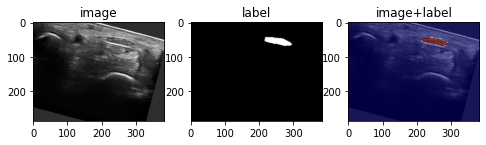

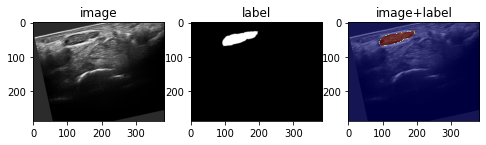

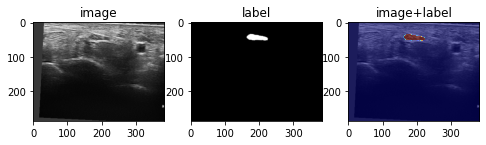

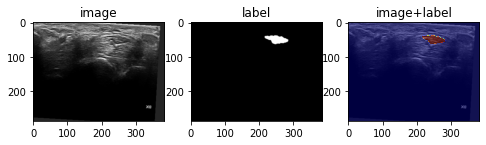

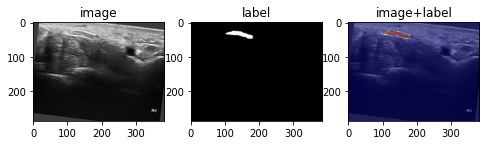

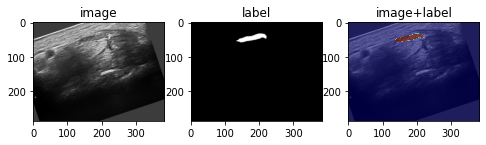

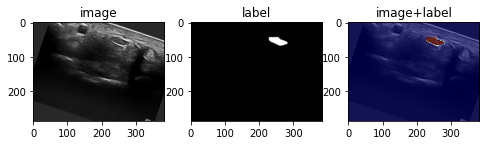

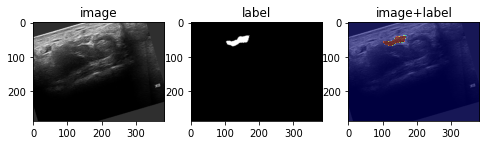

In [6]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

In [7]:
print(params["length_training"])
print(params['length_validation'])
print(len(dataset_list[0]['test']))

164
38
44


# Model definition & training

##Model training

In [8]:

'''
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

params['learningRate'] = lr_schedule
'''


params['learningRate'] = 1e-4
params['nEpoches'] = 100

models_name = ['unet', 'lightweight_unet', 'dbunet', 'dbunet_BNDrop']
arch_name = models_name[0]


!cp "$root_path/modules/models/{arch_name}.py" .
arch = importlib.import_module(arch_name)

input_size = (input_res[1], input_res[0], 1)

'''if 'dbunet' in arch_name:
  model = arch.build_model(input_size)
else:'''
initializer = tf.keras.initializers.GlorotUniform()
model = arch.build_model(initializer, input_size)

model_weights = f"{root_path}/dataset/results/models/{arch_name}_Glorot_e{params['nEpoches']}_lr{params['learningRate']}"
log_path = f"{model_weights}/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf $log_path

#model.summary()

In [9]:
model.count_params()

7858405

In [10]:
#model.load_weights("/content/drive/MyDrive/CVDL/trained_models/dbunet_BNDrop_drop0.2_vl.15395_test.2173/model.hdf5")

In [10]:
# Model savepath
#now = datetime.now()
#current_time = now.strftime("%H:%M:%S")

# Default loss, metric
#loss = 'binary_crossentropy'
#metric = 'accuracy'
loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

print(f'Model wil be saved in {model_weights}')

train_history, model = lib.train(model_weights, log_path, params, model, loss, metric, train_generator, val_generator)


Model wil be saved in /content/drive/MyDrive/CVDL/dataset/results/models/unet_Glorot_e100_lr0.0001
Epoch 1/100
21/21 [==============================] - 14s 368ms/step - loss: 1.2295 - dice: 0.0412 - iou: 0.1015 - recall: 0.6414 - precision: 0.0889 - val_loss: 1.5778 - val_dice: 0.0222 - val_iou: 9.0683e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.57776, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/unet_Glorot_e100_lr0.0001/Model.hdf5
Epoch 2/100
21/21 [==============================] - 4s 207ms/step - loss: 1.0745 - dice: 0.0698 - iou: 0.2744 - recall: 0.5074 - precision: 0.3610 - val_loss: 1.4569 - val_dice: 0.0229 - val_iou: 9.2960e-09 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

Epoch 00002: val_loss improved from 1.57776 to 1.45689, saving model to /content/drive/MyDrive/CVDL/dataset/results/models/unet_Glorot_e100_lr0.0001/Model.hdf5
Epoch 3/100
21/21 [==============================] - 4s 206m

##Model Testing

2/2 [==============================] - 3s 700ms/step - loss: 0.2006 - dice: 0.8083 - iou: 0.7367 - recall: 0.8203 - precision: 0.8296


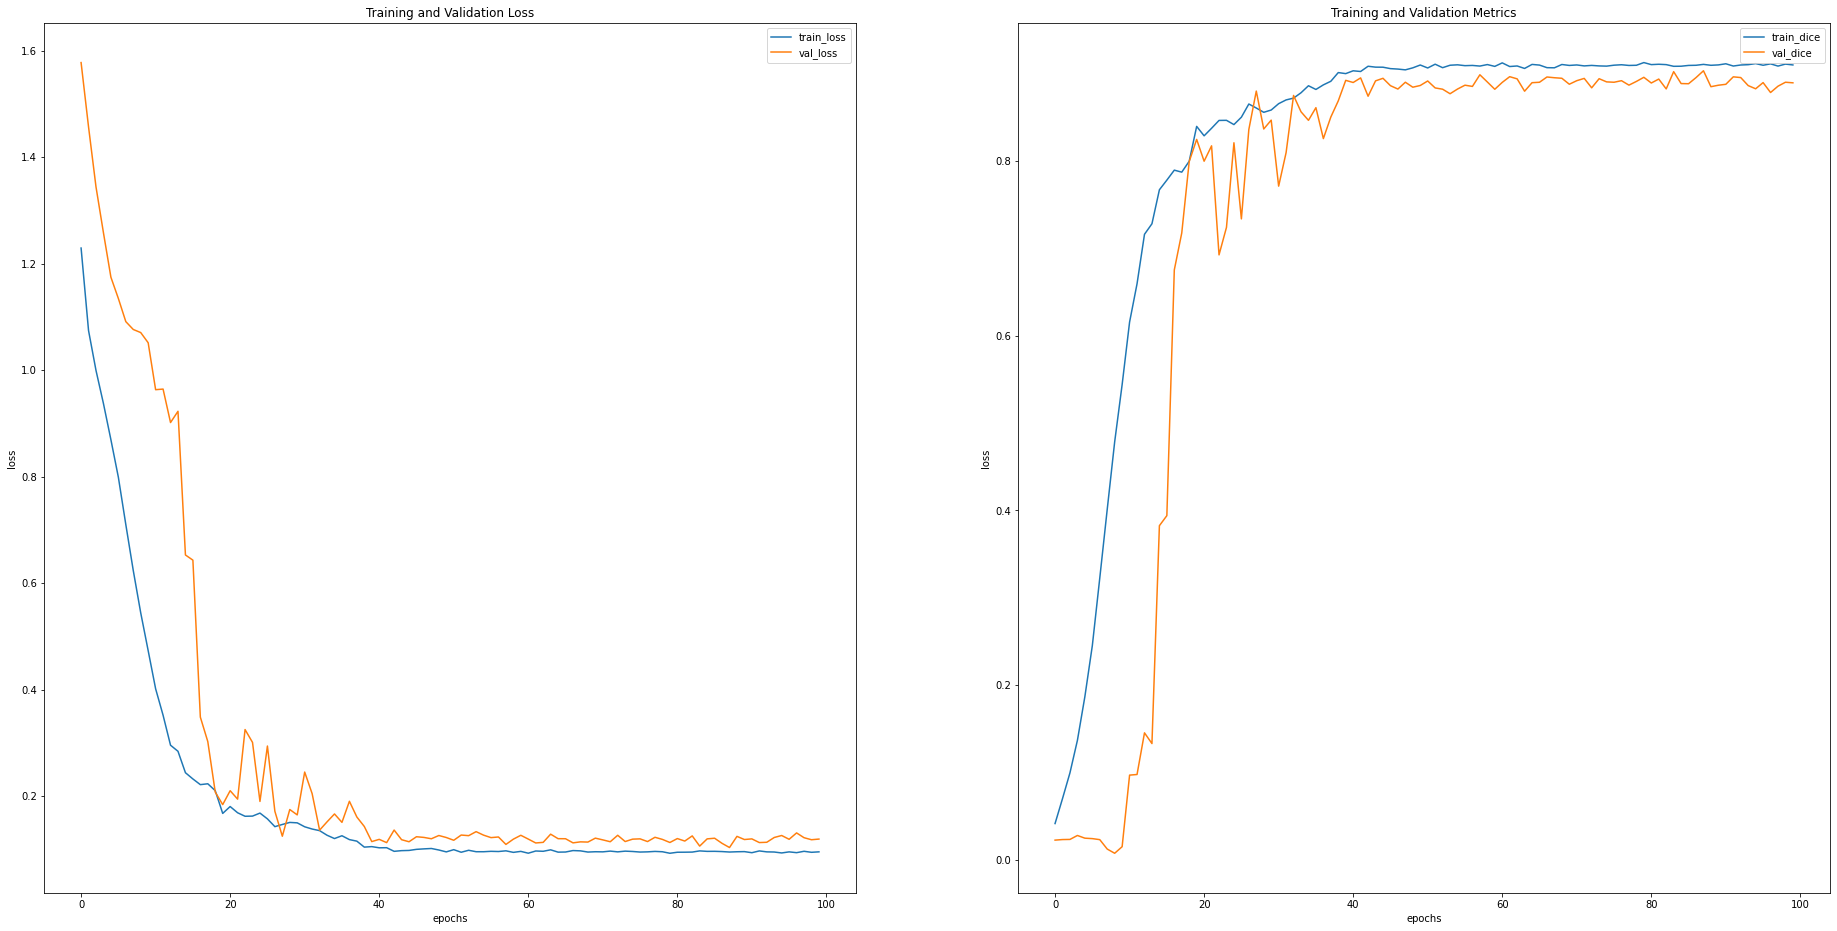

In [11]:
epoche = params['nEpoches']

results_tf = model.evaluate(dataset_list[0]['test'], dataset_list[1]['test'], return_dict = True)
train_figure = plots.plot_train_metric(train_history, epoche, "dice")
plt.show()

In [13]:
#name = f'{arch_name}_drop0.2_vl.15395_test.2173/'
lr = params['learningRate']

name = f'{arch_name}_lr{lr}_prenderequesto/'
model.save(f'/content/drive/MyDrive/CVDL/trained_models/{name}/model.hdf5')
train_figure.savefig(f'/content/drive/MyDrive/CVDL/trained_models/{name}/learning_curves.png')

In [12]:
threshold = 0.5
min_dice = 0.60
results_df, avg = plots.get_results(dataset_list, params, model, threshold)
print(results_df)
print('\n')
print(f"Threshold value: {threshold}")
print(f"Best dice: {max(results_df['dice'])}")
print(f"Average dice: {avg}")
print(f"Minimum requested dice value (bad samples): {min_dice}")
good_res = results_df.loc[(results_df['dice'] >= min_dice)]
print(f"Average dice without bad samples: {good_res['dice'].mean()}")

        dice
0   0.797601
1   0.841513
2   0.802803
3   0.888416
4   0.945269
5   0.781667
6   0.840376
7   0.898258
8   0.928510
9   0.921854
10  0.617682
11  0.712424
12  0.915084
13  0.532816
14  0.792350
15  0.901712
16  0.928183
17  0.616853
18  0.875264
19  0.614880
20  0.917415
21  0.933043
22  0.934918
23  0.949600
24  0.917861
25  0.912533
26  0.922674
27  0.907459
28  0.922955
29  0.940016
30  0.925926
31  0.947063
32  0.805819
33  0.935328
34  0.875979
35  0.887237
36  0.916342
37  0.853670
38  0.893716
39  0.728210
40  0.926476
41  0.885569
42  0.606516
43  0.349682


Threshold value: 0.5
Best dice: 0.9495996231747527
Average dice: {'dice': 0.8397617788548847}
Minimum requested dice value (bad samples): 0.6
Average dice without bad samples: 0.8587385825303742


        dice
13  0.532816
43  0.349682
0.045454545454545456


Loading bad samples... :






Image index 13 - dice: dice    0.532816
Name: 13, dtype: float64


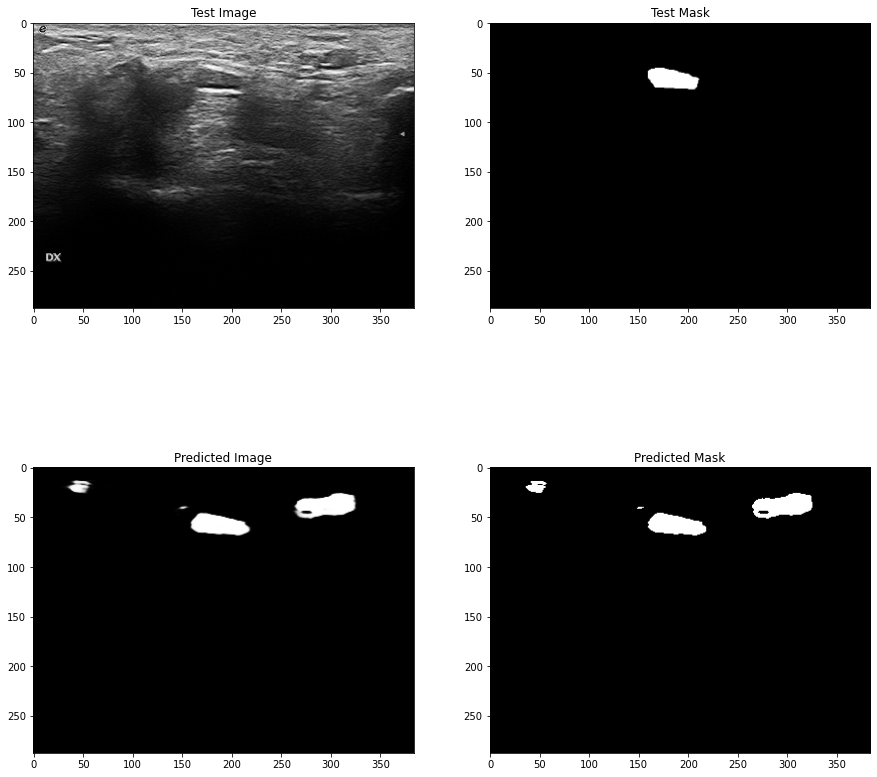





Image index 43 - dice: dice    0.349682
Name: 43, dtype: float64


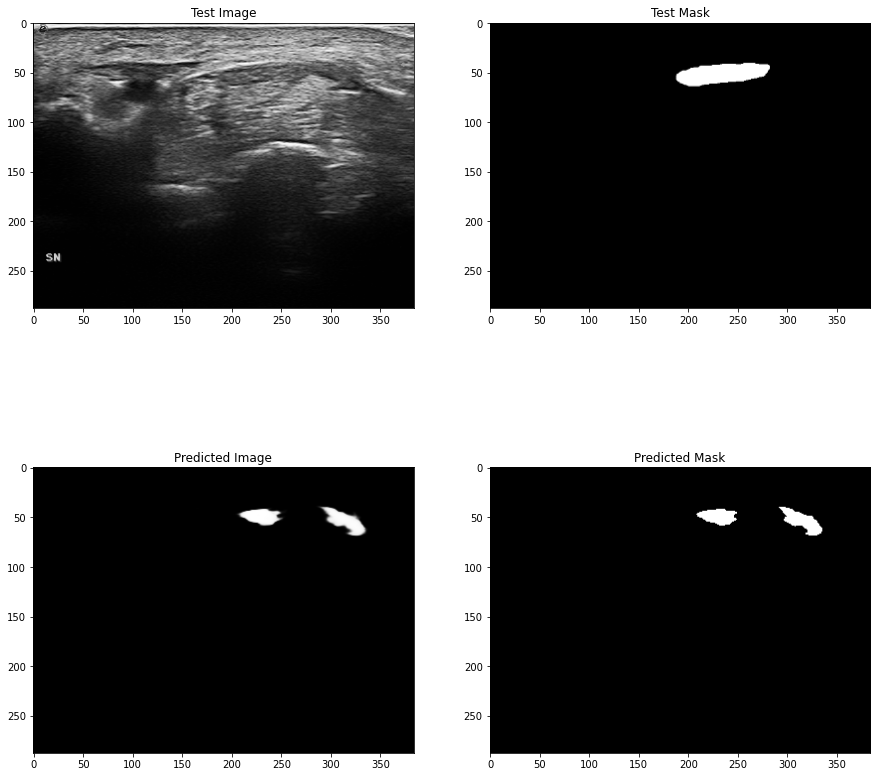

In [14]:
bad_res = results_df.loc[(results_df['dice'] < min_dice)]
print(bad_res)

num = bad_res['dice'].count()
den = results_df['dice'].count()

print(num/den)
print('\n')
print("Loading bad samples... :")
print('\n')
for idx in bad_res.index:
  print('\n')
  print('\n')
  print(f"Image index {idx} - dice: {bad_res.loc[idx]}")
  threshold = 0.5
  test_image = dataset_list[0]['test'][idx,:,:,0]
  test_mask = dataset_list[1]['test'][idx,:,:,0]
  test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)
  results_figure = plots.plot_test_results(test_results)

  plt.show()
results_figure.savefig(f'/content/drive/MyDrive/CVDL/trained_models/{name}/bad_samples.png')

testing accuracy: 0.9907045717592593
testing dice: 0.9495996231747527


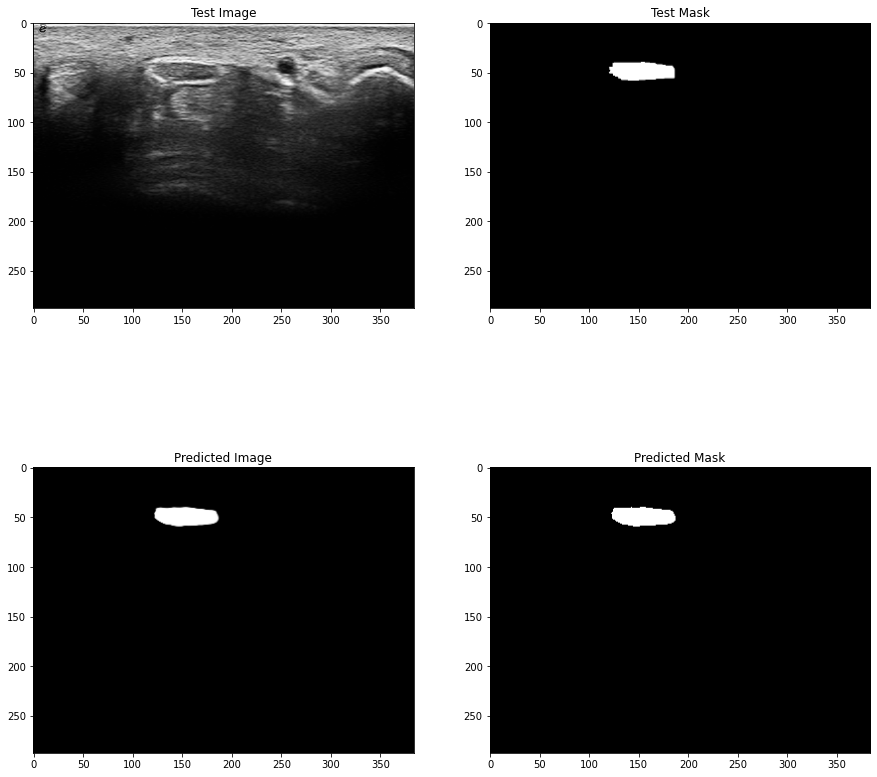

In [15]:
# Set the threshold for predictions
threshold = 0.5

# Select the image on which make 
image_index = 23
test_image = dataset_list[0]['test'][image_index,:,:,0]
test_mask = dataset_list[1]['test'][image_index,:,:,0]

test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)

print("testing accuracy:", lib.accuracy(test_mask, test_results["pred_mask"]))
print("testing dice:", lib.dice(test_mask, test_results["pred_mask"]))

results_figure = plots.plot_test_results(test_results)
plt.show()

## Dump Risultati

In [ ]:
#Dumping model 
model.save(f"{root_path}/dataset/results/models/{arch_name}_e{params['nEpoches']}_lr{params['learningRate']}")

NameError: ignored

In [ ]:
# Dump Risultati
lib.create_dump(results_tf, f"/content/drive/MyDrive/CVDL/results/{arch_name}/evaluate")
train_figure.savefig(f"/content/drive/MyDrive/CVDL/results/{arch_name}/figs")

In [ ]:
tf.keras.backend.clear_session()

NameError: ignored